# Implementations of the k-means clustering using Spark

### Group 12:
- Eugenio Fella
- Matteo Pedrazzi
- Gaetano Ricucci 
- Carlo Sgorlon Gaiatto

In [1]:
import sys
import time
import math
import csv
import numpy as np
import pandas as pd
from scipy import sparse as sp
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_rcv1

In [3]:
# set this variable with one of the following values:

# 'cloud-veneto-cluster' -> Spark standalone cluster
# 'docker-cluster' -> development Spark standalone cluster

CLUSTER_TYPE = 'cloud-veneto-cluster'

In [4]:
if CLUSTER_TYPE == 'cloud-veneto-cluster':
    
    import findspark
    
    # add pyspark to sys.path runtime
    findspark.init('/usr/local/spark')

    import boto3
    import urllib3

    urllib3.disable_warnings()
    
    # establish a connection to Cloud-Veneto's Amazon S3 buckets with Boto3
    s3 = boto3.client('s3',
                     endpoint_url = 'https://cloud-areapd.pd.infn.it:5210',
                     aws_access_key_id = '1d3f4d968ec14d53bcc4b8e6f6afd9e1',
                     aws_secret_access_key = '***insert key***',
                     verify = False)

# Load compressed [RCV1 dataset](https://scikit-learn.org/stable/datasets/real_world.html#rcv1-dataset)

In [5]:
rcv1 = fetch_rcv1(subset = 'all')

In [6]:
# attributes of rcv1 (dictionary-like object):
# data         -> scipy CSR sparse matrix
# target       -> scipy CSR sparse matrix
# target_names -> numpy array
# sample_id    -> numpy array

attributes_rcv1 = ['data', 'target', 'target_names', 'sample_id']
format_spec = '{:>12} {:>40} {:>16}'

print('RCV1 dataset attributes:\n')
print(format_spec.format('name:', 'class:', 'shape:'), '\n')

for attribute in attributes_rcv1:
    words = [attribute, type(getattr(rcv1, attribute)), getattr(rcv1, attribute).shape]
    words = [str(w) for w in words]
    print(format_spec.format(words[0], words[1], words[2]))

RCV1 dataset attributes:

       name:                                   class:           shape: 

        data   <class 'scipy.sparse._csr.csr_matrix'>  (804414, 47236)
      target   <class 'scipy.sparse._csr.csr_matrix'>    (804414, 103)
target_names                  <class 'numpy.ndarray'>           (103,)
   sample_id                  <class 'numpy.ndarray'>        (804414,)


In [7]:
# attributes of scipy CSR sparse matrix (CSR = Compressed Sparse Row):
# data    -> CSR format data array of the matrix
# indices -> CSR format index array of the matrix
# indptr  -> CSR format index pointer array of the matrix

attributes_CSR = ['data', 'indices', 'indptr']
format_spec = '{:>10} {:>25} {:>12} {:>14}'
    
for i in range(2):
    
    csr = getattr(rcv1, attributes_rcv1[i])
    
    if i == 1: print('\n\n')
    print('{} CSR sparse matrix attributes:\n'.format(attributes_rcv1[i]))
    print(format_spec.format('name:', 'class:', 'shape:', 'size [Mb]:'), '\n')

    for attribute in attributes_CSR:

        x = getattr(csr, attribute)
        words = [attribute, type(x), x.shape, round(x.nbytes/10**6, 4)]
        words = [str(w) for w in words]
        print(format_spec.format(words[0], words[1], words[2], words[3]))

data CSR sparse matrix attributes:

     name:                    class:       shape:     size [Mb]: 

      data   <class 'numpy.ndarray'>  (60915113,)       487.3209
   indices   <class 'numpy.ndarray'>  (60915113,)       243.6605
    indptr   <class 'numpy.ndarray'>    (804415,)         3.2177



target CSR sparse matrix attributes:

     name:                    class:       shape:     size [Mb]: 

      data   <class 'numpy.ndarray'>   (2606875,)         2.6069
   indices   <class 'numpy.ndarray'>   (2606875,)        10.4275
    indptr   <class 'numpy.ndarray'>    (804415,)         3.2177


# Split compressed RCV1 dataset into chunks and save them

In [8]:
# define the number of rows for each chunk
rows_per_chunk = 16000
# define number of chunks
n_chunk = 32
# compute total number of selected documents 
tot_docs = rows_per_chunk*n_chunk
print('number of selected documents:', tot_docs)

number of selected documents: 512000


In [9]:
if CLUSTER_TYPE == 'cloud-veneto-cluster':

    for i in range(n_chunk):

        # save data CSR sparse matrix chunk
        sp.save_npz('rcv1_dataset/data_{}.npz'.format(i),
                    rcv1.data[rows_per_chunk*(i):rows_per_chunk*(i+1)],
                    compressed = True)

        # save target CSR sparse matrix chunk
        sp.save_npz('rcv1_dataset/target_{}.npz'.format(i),
                    rcv1.target[rows_per_chunk*(i):rows_per_chunk*(i+1)],
                    compressed = True)

        # upload chunks into 'mapd-gr12' Amazon S3 bucket
        s3.upload_file('rcv1_dataset/data_{}.npz'.format(i), 'mapd-gr12', 'data_{}.npz'.format(i))
        s3.upload_file('rcv1_dataset/target_{}.npz'.format(i), 'mapd-gr12', 'target_{}.npz'.format(i))  
        
elif CLUSTER_TYPE == 'docker-cluster':
    
    for i in range(n_chunk):
    
        # save data CSR sparse matrix chunk
        sp.save_npz('rcv1_dataset/data_{}.npz'.format(i),
                    rcv1.data[rows_per_chunk*(i):rows_per_chunk*(i+1)],
                    compressed = True)

        # save target CSR sparse matrix chunk
        sp.save_npz('rcv1_dataset/target_{}.npz'.format(i),
                    rcv1.target[rows_per_chunk*(i):rows_per_chunk*(i+1)],
                    compressed = True)

In [10]:
# inspect a single chunk
format_spec = '{:>10} {:>25} {:>12} {:>14}'

for i in range(2):
    
    # loading method
    csr = sp.load_npz('rcv1_dataset/{}_0.npz'.format(attributes_rcv1[i]))
    
    if i == 1: print('\n\n')
    print('{}_0 CSR sparse matrix chunk attributes:\n'.format(attributes_rcv1[i]))
    print(format_spec.format('name:', 'class:', 'shape:', 'size [Mb]:'), '\n')

    for attribute in attributes_CSR:

        x = getattr(csr, attribute)
        words = [attribute, type(x), x.shape, round(x.nbytes/10**6, 4)]
        words = [str(w) for w in words]
        print(format_spec.format(words[0], words[1], words[2], words[3]))

data_0 CSR sparse matrix chunk attributes:

     name:                    class:       shape:     size [Mb]: 

      data   <class 'numpy.ndarray'>   (1203897,)         9.6312
   indices   <class 'numpy.ndarray'>   (1203897,)         4.8156
    indptr   <class 'numpy.ndarray'>     (16001,)          0.064



target_0 CSR sparse matrix chunk attributes:

     name:                    class:       shape:     size [Mb]: 

      data   <class 'numpy.ndarray'>     (50731,)         0.0507
   indices   <class 'numpy.ndarray'>     (50731,)         0.2029
    indptr   <class 'numpy.ndarray'>     (16001,)          0.064


# Build the Spark session

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [12]:
if CLUSTER_TYPE == 'cloud-veneto-cluster':

    spark = SparkSession.builder \
        .master('spark://master:7077')\
        .appName('k_means_application')\
        .config('spark.driver.host','10.67.22.104')\
        .config('spark.executor.memory', '1g')\
        .config('spark.executor.cores', '1')\
        .config('spark.default.parallelism', '32')\
        .getOrCreate()
    
elif CLUSTER_TYPE == 'docker-cluster':
    
    spark = SparkSession.builder \
        .master('spark://spark-master:7077')\
        .appName('k_means_application')\
        .config('spark.executor.memory', '512m')\
        .config('spark.executor.cores', '1')\
        .config('spark.default.parallelism', '2')\
        .getOrCreate()

# get the SparkSession
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/11 19:52:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
# get the SparkContext
sc = spark.sparkContext

sc

<SparkContext master=spark://master:7077 appName=k_means_application>

# Read the files in parallel with Spark and select only one-label documents

We only select one-label documents, as k-means clustering assigns each point to a single cluster. We have considered all sub-labels and not only the macro-labels, in order to have a larger number of clusters necessary to properly test the different execution times of the k-means++ and k-means|| initialization methods.

In [14]:
# creates a list of file names

if CLUSTER_TYPE == 'cloud-veneto-cluster':

    file_list = [('data_{}.npz'.format(i), 'target_{}.npz'.format(i)) for i in range(n_chunk)]
    
elif CLUSTER_TYPE == 'docker-cluster':
    
    files_path = '/opt/workspace/rcv1_dataset/'
    file_list = [(files_path + 'data_{}.npz'.format(i),
                  files_path + 'target_{}.npz'.format(i)) for i in range(n_chunk)]

# parallelize the list of file names
files_rdd = sc.parallelize(file_list)
files_rdd.collect()

[('data_0.npz', 'target_0.npz'),
 ('data_1.npz', 'target_1.npz'),
 ('data_2.npz', 'target_2.npz'),
 ('data_3.npz', 'target_3.npz'),
 ('data_4.npz', 'target_4.npz'),
 ('data_5.npz', 'target_5.npz'),
 ('data_6.npz', 'target_6.npz'),
 ('data_7.npz', 'target_7.npz'),
 ('data_8.npz', 'target_8.npz'),
 ('data_9.npz', 'target_9.npz'),
 ('data_10.npz', 'target_10.npz'),
 ('data_11.npz', 'target_11.npz'),
 ('data_12.npz', 'target_12.npz'),
 ('data_13.npz', 'target_13.npz'),
 ('data_14.npz', 'target_14.npz'),
 ('data_15.npz', 'target_15.npz'),
 ('data_16.npz', 'target_16.npz'),
 ('data_17.npz', 'target_17.npz'),
 ('data_18.npz', 'target_18.npz'),
 ('data_19.npz', 'target_19.npz'),
 ('data_20.npz', 'target_20.npz'),
 ('data_21.npz', 'target_21.npz'),
 ('data_22.npz', 'target_22.npz'),
 ('data_23.npz', 'target_23.npz'),
 ('data_24.npz', 'target_24.npz'),
 ('data_25.npz', 'target_25.npz'),
 ('data_26.npz', 'target_26.npz'),
 ('data_27.npz', 'target_27.npz'),
 ('data_28.npz', 'target_28.npz'),
 ('da

In [15]:
# get the names of all possible labels (both macro and sub)
target_names = rcv1.target_names

In [16]:
# function to download, load and read files in parallel with Spark
# and perform an initial filter operation selecting only one-label documents

if CLUSTER_TYPE == 'cloud-veneto-cluster':
    
    def parse_file(file, target_names):

        # list of macro-labels
        target_names_macro = ['CCAT', 'ECAT', 'GCAT', 'MCAT']  

        s3 = boto3.client('s3',
                     endpoint_url = 'https://cloud-areapd.pd.infn.it:5210',
                     aws_access_key_id = '1d3f4d968ec14d53bcc4b8e6f6afd9e1',
                     aws_secret_access_key = '***insert key***',
                     verify = False)

        # download files from s3
        s3.download_file('mapd-gr12', file[0] ,'/home/Project/rcv1_dataset/' + file[0])
        s3.download_file('mapd-gr12', file[1] ,'/home/Project/rcv1_dataset/' + file[1])

        # load sparse matricies
        data = sp.load_npz('/home/Project/rcv1_dataset/' + file[0])
        target = sp.load_npz('/home/Project/rcv1_dataset/' + file[1])

        # list of documents
        rows = [] 

        # loop over documents in the chunk
        for i in range(data.shape[0]):

            # get indices of non-zero labels of the i-th document
            indices = target.indices[target.indptr[i]:target.indptr[i+1]]

            # check if there are only two labels
            if len(indices) == 2:

                # get the 2 labels of the i-th document
                labels = [target_names[i] for i in indices]

                # check if there is at least 1 macro-label AND
                # check if both labels belong to the same macro-label
                if (any(c in labels for c in target_names_macro) and len(set([c[0] for c in labels])) == 1):

                    # select the sub-label
                    label = [l for l in labels if l not in target_names_macro][0]

                    # build a dictionary containing the non-zero features of the i-th document
                    keys = [str(i) for i in data.indices[data.indptr[i]:data.indptr[i+1]]]
                    values = data.data[data.indptr[i]:data.indptr[i+1]].tolist()
                    features = dict(zip(keys, values))

                    rows.append((label,features))           

        return rows

In [17]:
# function to load and read files in parallel with Spark
# and perform an initial filter operation selecting only one-label documents

if CLUSTER_TYPE == 'docker-cluster':
    
    def parse_file(file, target_names):
    
        # list of macro-labels
        target_names_macro = ['CCAT', 'ECAT', 'GCAT', 'MCAT']

        # load sparse matricies
        data = sp.load_npz(file[0])
        target = sp.load_npz(file[1])

        # list of documents
        rows = [] 

        # loop over documents in the chunk
        for i in range(data.shape[0]):

            # get indices of non-zero labels of the i-th document
            indices = target.indices[target.indptr[i]:target.indptr[i+1]]

            # check if there are only two labels
            if len(indices) == 2:

                # get the 2 labels of the i-th document
                labels = [target_names[i] for i in indices]

                # check if there is at least 1 macro-label AND
                # check if both labels belong to the same macro-label
                if (any(c in labels for c in target_names_macro) and len(set([c[0] for c in labels])) == 1):

                    # select the sub-label
                    label = [l for l in labels if l not in target_names_macro][0]

                    # build a dictionary containing the non-zero features of the i-th document
                    keys = [str(i) for i in data.indices[data.indptr[i]:data.indptr[i+1]]]
                    values = data.data[data.indptr[i]:data.indptr[i+1]].tolist()
                    features = dict(zip(keys, values))

                    rows.append((label,features))           

        return rows

In [18]:
# get the size of a parse chunk
parse_chunk = parse_file(file_list[0], target_names)
parse_chunk_size = 0

for i in range(len(parse_chunk)):
    parse_chunk_size += sys.getsizeof(parse_chunk[i][0]) + sys.getsizeof(parse_chunk[i][1])

print('size of a parse chunk:', round(parse_chunk_size/10**6, 2), 'Mb')

size of a parse chunk: 14.98 Mb


In [19]:
# persist tha dataset in memory
data_rdd = files_rdd.flatMap(lambda file: parse_file(file, target_names)).persist()

In [20]:
# trigger the caching
print('number of documents in the loaded dataset:', rows_per_chunk*n_chunk)
print('number of one-label documents in the loaded dataset:', data_rdd.count())

number of documents in the loaded dataset: 512000


number of one-label documents in the loaded dataset: 131844


# Visualize clusters population

Clusters information:

  macro-label:    number of sub-labels:      population: 

          CCAT                       18            31774
          ECAT                       10             8233
          GCAT                       21            56235
          MCAT                        4            35602

                                  total:           total:
                                     53           131844


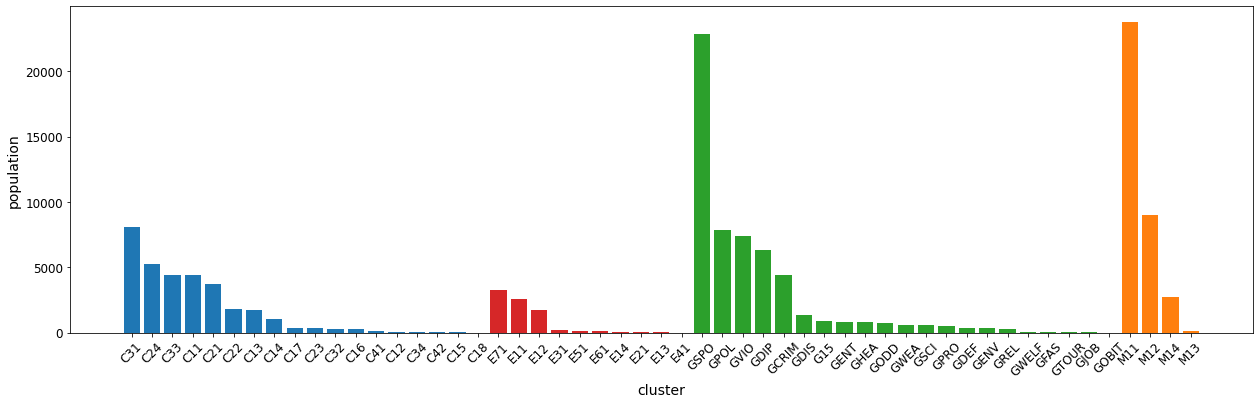

In [21]:
def visualize_clusters_pop(labels_dict):
    
    macros = ['CCAT', 'ECAT', 'GCAT', 'MCAT']    
    colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
    
    keys = []
    values = []
    color_list = []
    
    format_spec = '{:>14} {:>24} {:>16}'
    
    print('Clusters information:\n')
    print(format_spec.format('macro-label:', 'number of sub-labels:', 'population:'), '\n')
    
    # get population of each sub-label sorted by values and grouped by macro-label
    for i, macro in enumerate(macros):

        # create a sorted dictionary of sub-labels belonging to the same macro-label
        d = dict([(key, labels_dict[key]) for key in labels_dict.keys() if key[0] == macro[0]])
        d = dict(sorted(d.items(), key = lambda item: -item[1]))

        keys += [*d]
        values += [*d.values()] 
        color_list += [colors[i]]*len(d)

        print(format_spec.format(macro, str(len(d)), str(np.sum([*d.values()]))))

    print('\n', format_spec.format('', 'total:', 'total:'))
    print(format_spec.format('', str(len(values)), str(np.sum(values))))

    # plot
    fig, ax = plt.subplots(figsize = (0.4*len(values),6))
    ax.bar(keys, values, color = color_list)
    ax.set_xlabel('cluster', fontsize = 14)
    ax.set_ylabel('population', fontsize = 14)
    plt.xticks(fontsize = 12, rotation = 45)
    plt.yticks(fontsize = 12)
    plt.show()
        
clusters_dict = data_rdd.countByKey()
visualize_clusters_pop(clusters_dict)

# Clusters filter

We only select clusters with nearly homogeneous populations, as k-means clustering requires clusters to be of similar size in order to work properly.

In [22]:
# sort the dictionary containing the population of each cluster
clusters_dict = {k: clusters_dict[k] for k in sorted(clusters_dict, key = clusters_dict.get, reverse = True)}

# get population of each cluster
clusters_pop = np.array([*clusters_dict.values()]) 

# define thresholds to select only clusters with homogeneous populations
threshold_high = 0.125*np.sum(clusters_pop)
threshold_low = 0.0225*np.sum(clusters_pop)

# get filtered clusters
filter_index_high = np.max(np.where(clusters_pop > threshold_high)) + 1
filter_index_low = np.max(np.where(clusters_pop > threshold_low)) + 1
filtered_clusters = [*clusters_dict][filter_index_high:filter_index_low]

print('Number of selected clusters: ', filter_index_low - filter_index_high, '\n')
print(filtered_clusters)

Number of selected clusters:  11 

['M12', 'C31', 'GPOL', 'GVIO', 'GDIP', 'C24', 'C33', 'C11', 'GCRIM', 'C21', 'E71']


Clusters information:

  macro-label:    number of sub-labels:      population: 

          CCAT                        5            25796
          ECAT                        1             3273
          GCAT                        4            25895
          MCAT                        1             9017

                                  total:           total:
                                     11            63981


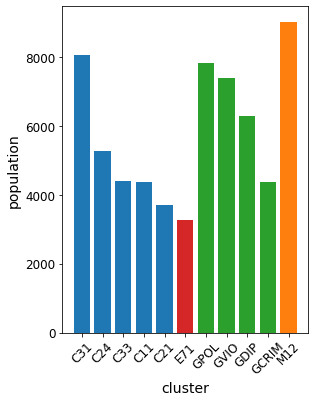

In [23]:
# filter the RDD
filtered_clusters_dict = data_rdd \
                    .filter(lambda el: el[0] in filtered_clusters) \
                    .countByKey()

visualize_clusters_pop(filtered_clusters_dict)

In [24]:
# fix the number of clusters
k = len(filtered_clusters_dict)

# Features filter
The data features are represented by cosine-normalized, log TF-IDF vectors. Therefore we can reduce the dimensionality of the points by aggregating the features using the sum operation and selecting only the most important ones.

In [25]:
# function to sum the values of two dictionaries by keys
def sum_dictionary(el1, el2):
    
    dict_sum = {key: el1.get(key, 0) + el2.get(key, 0) for key in set([*el1]+[*el2])}
    
    # return a tuple as rdd element
    return ('total', dict_sum)

In [26]:
# create a sorted dictionary of the aggregated features
features_dict = data_rdd \
            .filter(lambda el: el[0] in filtered_clusters) \
            .reduce(lambda el1, el2: sum_dictionary(el1[1], el2[1]))[1]

features_dict = {key: features_dict[key] for key in sorted(features_dict, key = features_dict.get, reverse = True)}

number of selected features: 920


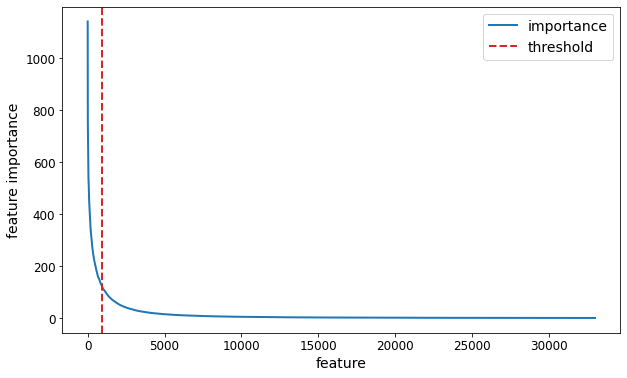

In [27]:
# compute the cumulative sum
cumsum_features_dict = np.cumsum([*features_dict.values()])

# define a threshold to select only a fraction of the features
threshold = 0.5*cumsum_features_dict[-1]

# get filtered features
filter_index = np.min(np.where(cumsum_features_dict > threshold))
filtered_features = [*features_dict][:filter_index]
print('number of selected features:', filter_index)

# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(len(features_dict)), features_dict.values(), lw = 2, label = 'importance')
ax.axvline(x = filter_index, color = 'tab:red', ls = '--', lw = 2, label = 'threshold')
ax.set_xlabel('feature', fontsize = 14)
ax.set_ylabel('feature importance', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.show()

In [28]:
# function to remove not selected features
def filter_features(el, filtered_keys):
    
    filtered_dict = {key: el[key] for key in filtered_keys if key in el}
    
    return filtered_dict

In [29]:
# persist the dataset in memory after the clusters and features filters
data_rdd_filtered = data_rdd \
                .filter(lambda el: el[0] in filtered_clusters) \
                .mapValues(lambda el: filter_features(el, filtered_features)) \
                .persist()

# trigger the caching
data_rdd_filtered.count()

63981

In [30]:
# free up memory
data_rdd.unpersist()

PythonRDD[1] at RDD at PythonRDD.scala:53

# K-means clustering

In this section, we define some UDFs that we are going to use in the implementation of the k-means clustering algorithm.

In [31]:
# function to assign each point to a cluster
def assign_cluster(el, C):
    
    # compute the squared distance using the first centroid
    d2_dict = {key: (el.get(key, 0) - C[0].get(key, 0))**2 for key in set([*el]+[*C[0]])}
    d2_min = np.sum([*d2_dict.values()])      
    cluster_ID = str(0)

    # loop over the remaining k - 1 centroids
    for k in range(1, len(C)):
        d2_dict = {key: (el.get(key, 0) - C[k].get(key, 0))**2 for key in set([*el]+[*C[k]])}
        d2 = np.sum([*d2_dict.values()])
        
        # update the minimum squared distance 
        if d2 < d2_min:
            d2_min = d2
            cluster_ID = str(k)
               
    return (cluster_ID, el)

In [32]:
# function to sum sparse dictionaries
def sum_points(el1, el2):
    dict_sum = {key: el1.get(key,0) + el2.get(key,0) for key in set([*el1]+[*el2])}    
    return dict_sum

In [33]:
# function to compute centroids given labelled documents 
def compute_centroids(el, pop_clusters):
    
    cluster_ID = el[0]
    pop = pop_clusters[cluster_ID]
    
    keys = [*el[1]]
    values = [v/pop for v in [*el[1].values()]]
    
    return (cluster_ID, dict(zip(keys, values)))

In [34]:
# function to calculate the squared distance to the nearest centroid
def compute_d2(el, C):
    
    # compute the squared distance using the first centroid
    d2_dict = {key: (el.get(key, 0) - C[0].get(key, 0))**2 for key in set([*el]+[*C[0]])}
    d2_min = np.sum([*d2_dict.values()])      

    # loop over the remaining k - 1 centroids
    for k in range(1, len(C)):
        d2_dict = {key: (el.get(key, 0) - C[k].get(key, 0))**2 for key in set([*el]+[*C[k]])}
        d2 = np.sum([*d2_dict.values()])
        
        # update the minimum squared distance
        if d2 < d2_min:
            d2_min = d2
            
    return d2_min

# Baseline cost
We compute the cost function using the human assigned labels.

In [35]:
def compute_base_cost(label, el, C):
    
    c = [c[1] for c in C if c[0] == label][0]
    d2_dict = {key: (el.get(key, 0) - c[key])**2 for key in [*c]}
    d2 = np.sum([*d2_dict.values()])      
            
    return d2

In [36]:
C_base = data_rdd_filtered \
        .reduceByKey(lambda el1, el2: sum_points(el1, el2)) \
        .map(lambda el: compute_centroids(el, filtered_clusters_dict)) \
        .collect()

base_cost = data_rdd_filtered \
        .map(lambda el: compute_base_cost(el[0], el[1], C_base)) \
        .reduce(lambda x, y: x + y)

# Naive (Forgy) initialization

In [37]:
def naive_init(k, data_rdd, seed):
    
    print('naive initialization started ...')
    
    # select k cetroids uniformly at random at once
    C = data_rdd.takeSample(False, k, seed) # return a list with k tuples
    C = [c[1] for c in C]
    
    return C

# K-means++ initialization

In [38]:
def k_means_pp_init(k, data_rdd, seed, verbose = 0):
    
    print('k-means ++ initialization started ...')
    if verbose == 1: print('')
       
    np.random.seed(seed)
    
    # centroids list
    C = []
    
    # select first centroid uniformly at random
    c = data_rdd.takeSample(False, 1, seed) # return a list with 1 tuple
    C.append(c[0][1])
    
    # select the remaining k-1 centroids
    for i in range(k-1):
        
        if verbose == 1: print('iteration:', i+1)
          
        # persist the dataset in memory after computing the squared distance
        data_rdd_cached = data_rdd \
                        .map(lambda el: (compute_d2(el[1], C), el[1])) \
                        .persist()
        
        # compute cost and trigger the caching
        cost = data_rdd_cached \
            .reduce(lambda x, y: (x[0] + y[0], ''))[0]
        
        # weighted sampling
        c = data_rdd_cached \
            .map(lambda el: (True, el[1]) if np.random.uniform(size = 1) < el[0]/cost else (False, el[1])) \
            .filter(lambda el: el[0]) \
            .takeSample(False, 1, seed) # return a list with at most 1 tuple
        
        if len(c) == 0:
            
            if verbose == 1: print('-> failed weighted sampling: take highest probabilty')
            
            # get centroid with the highest probabilty (unnormalized)
            c = data_rdd_cached \
                .reduce(lambda el1, el2: el1 if (el1[0] >= el2[0]) else el2) # return 1 tuple
            
            C.append(c[1])
            
        else:
            
            C.append(c[0][1]) 
            
        # free up memory
        data_rdd_cached.unpersist()
                
    return C

# K-means|| initialization

In [39]:
def k_means_ll_init(k, data_rdd, seed, l = 2, t = 5, verbose = 0):
    
    print('k-means || initialization started ...')
    
    np.random.seed(seed)
    
    # centroids list
    C = []
    
    # select first centroid uniformly at random
    c = data_rdd.takeSample(False, 1, seed) # return a list with 1 tuple
    C.append(c[0][1])
    
    # compute cost
    cost = data_rdd.map(lambda el: compute_d2(el[1], C)) \
        .reduce(lambda x, y: x + y)
    
    #t = math.floor(math.log(cost))
    if verbose == 1: print('\ntheoretical number of iterations:', math.floor(math.log(cost)), '\n')
      
    for i in range(t):
        
        if verbose == 1: print('iteration:', i+1)
            
        # persist the dataset in memory after computing the squared distance
        data_rdd_cached = data_rdd \
                        .map(lambda el: (compute_d2(el[1], C), el[1])) \
                        .persist()
        
        if i != 0:
            # compute cost and trigger the caching
            cost = data_rdd_cached \
                .reduce(lambda x, y: (x[0] + y[0], ''))[0]

        #  compute normalize probs and multiply by the oversampling factor
        #  weighted sampling
        #  get new centroids       
        rows = data_rdd_cached \
            .map(lambda el: (True, el[1]) if np.random.uniform(size = 1) < l*el[0]/cost else (False, el[1])) \
            .filter(lambda el: el[0]) \
            .collect() # return a list with a variable number of tuples
        
        c_list = [row[1] for row in rows]
        C += c_list     

        if verbose == 1: print('-> number of selected centroids:', len(c_list))
            
        # free up memory
        data_rdd_cached.unpersist()
        
    if verbose == 1: print('\ntotal number of centroids:', len(C))
    
    if len(C) > k:
        
        print('\nre-clustering started ...\n')
        
        # select k centroids from C using k-means ++
        C_rdd = sc.parallelize([('', c) for c in C])
        C = k_means_pp_init(k, C_rdd, seed, 0)
        
        if verbose == 1: print('\ntotal number of centroids after re-clustering:', len(C))
           
    return C

# Lloyd's algorithm

In [40]:
def lloyd_algorithm(data_rdd, C, cost_list, t):
    
    print("Lloyd's algorithm started ...\n")
    
    # compute initialization cost
    cost = data_rdd \
        .map(lambda el: compute_d2(el[1], C)) \
        .reduce(lambda x, y: x + y)
    
    cost_list.append(cost)
    
    print('cost (init):', np.round(cost, 2), '\n')
    
    for i in range(t):
        
        # persist the dataset in memory after cluster assignment
        data_rdd_cached = data_rdd \
                        .map(lambda el: assign_cluster(el[1], C)) \
                        .persist()

        # compute clusters population and trigger caching 
        pop_clusters = data_rdd_cached.countByKey()

        # compute new centroids
        C = data_rdd_cached \
            .reduceByKey(lambda el1, el2: sum_points(el1, el2)) \
            .map(lambda el: compute_centroids(el, pop_clusters)) \
            .values() \
            .collect()
        
        # compute new cost
        cost_best = data_rdd \
                .map(lambda el: compute_d2(el[1], C)) \
                .reduce(lambda x, y: x + y)
        
        cost_list.append(cost_best)
        
        # free up memory
        data_rdd_cached.unpersist()

        print('iteration:', i+1)
        print('cost:', np.round(cost_best, 2))
        print('reduction:', np.round(100*(cost - cost_best)/cost, 3), '%\n')
        
        cost = cost_best
        
    return C, cost_list

# Run k-means clustering

In [43]:
print('number of clusters:', k)

number of clusters: 11


In [45]:
# set this variable with one of the following values:

# 'naive'      -> naive (Forgy) initialization
# 'k-means-pp' -> k-means++ initialization
# 'k-means-ll' -> k-means|| initialization

init_method = 'k-means-ll'

# initial centroids
C = []

start_time = time.time()

if init_method == 'naive':
    C = naive_init(k, data_rdd_filtered, seed = 54321)
    
elif init_method == 'k-means-pp':
    C = k_means_pp_init(k, data_rdd_filtered, seed = 54321, verbose = 1)
    
elif init_method == 'k-means-ll':
    C = k_means_ll_init(k, data_rdd_filtered, seed = 54321, l = 3, t = 4, verbose = 1)
    if len(C) != k:
        print('ERROR: increase the oversampling factor l or the number of iterations t')

end_time = time.time()

t_init = end_time - start_time

print('\ninitialization time: {} s'.format(str(round(t_init, 2))))

k-means || initialization started ...

theoretical number of iterations: 10 

iteration: 1
-> number of selected centroids: 4
iteration: 2


-> number of selected centroids: 2
iteration: 3


-> number of selected centroids: 4
iteration: 4


-> number of selected centroids: 6

total number of centroids: 17

re-clustering started ...

k-means ++ initialization started ...

total number of centroids after re-clustering: 11

initialization time: 13.84 s


In [46]:
cost_list = [base_cost]
print('cost (base):', round(cost_list[0], 2))

cost (base): 20587.19


In [47]:
start_time = time.time()

C, cost_list = lloyd_algorithm(data_rdd_filtered, C, cost_list, t = 24)

end_time = time.time()

t_lloyd = end_time - start_time

print('Lloyd’s algorithm time: {} s'.format(str(round(t_lloyd, 2))))

Lloyd's algorithm started ...



cost (init): 34886.88 



iteration: 1
cost: 20696.4
reduction: 40.676 %



iteration: 2
cost: 20258.74
reduction: 2.115 %



iteration: 3
cost: 20164.2
reduction: 0.467 %



iteration: 4
cost: 20136.23
reduction: 0.139 %



iteration: 5
cost: 20128.35
reduction: 0.039 %



iteration: 6
cost: 20122.91
reduction: 0.027 %



iteration: 7
cost: 20115.6
reduction: 0.036 %



iteration: 8
cost: 20110.92
reduction: 0.023 %



iteration: 9
cost: 20107.61
reduction: 0.016 %



iteration: 10
cost: 20104.18
reduction: 0.017 %



iteration: 11
cost: 20100.41
reduction: 0.019 %



iteration: 12
cost: 20095.64
reduction: 0.024 %



iteration: 13
cost: 20089.02
reduction: 0.033 %



iteration: 14
cost: 20081.91
reduction: 0.035 %



iteration: 15
cost: 20076.09
reduction: 0.029 %



iteration: 16
cost: 20069.58
reduction: 0.032 %



iteration: 17
cost: 20062.5
reduction: 0.035 %



iteration: 18
cost: 20048.16
reduction: 0.071 %



iteration: 19
cost: 20027.93
reduction: 0.101 %



iteration: 20
cost: 20021.68
reduction: 0.031 %



iteration: 21
cost: 20014.63
reduction: 0.035 %



iteration: 22
cost: 20002.45
reduction: 0.061 %



iteration: 23
cost: 19975.67
reduction: 0.134 %



iteration: 24
cost: 19958.09
reduction: 0.088 %

Lloyd’s algorithm time: 822.8 s


In [48]:
print('total time: {} s'.format(str(round(t_init + t_lloyd, 2))))

total time: 836.64 s


In [49]:
# free up memory
data_rdd_filtered.unpersist()

PythonRDD[6] at RDD at PythonRDD.scala:53

# Deleting files local and on cloud

In [50]:
if CLUSTER_TYPE == 'cloud-veneto-cluster':

    import subprocess

    # delete files on all nodes
    def deleting(dummy):
        subprocess.call('rm /home/Project/rcv1_dataset/*', shell = True)
    
    files_rdd.map(lambda file: deleting(file)).count()

In [51]:
if CLUSTER_TYPE == 'cloud-veneto-cluster':

    # delete files on cloud
    for i in range(n_chunk):
        s3.delete_object(Bucket = 'mapd-gr12', Key = 'data_{}.npz'.format(i))
        s3.delete_object(Bucket = 'mapd-gr12', Key = 'target_{}.npz'.format(i))

In [52]:
# stop the running Spark context
sc.stop()
# stop the running Spark session
spark.stop()

# Compare the perfomances with different initializations: cost function
The dataset we used for this comparison consisted of 32 chunks of 16000 documents each, divided into 32 partitions, while the Spark cluster consisted of 16 executors, each with 1 core and 1 Gb of memory. From the graph below, it can be seen that the k-means algorithm with naive initialization requires more iterations to reach an arbitrarily set threshold of the cost function than the cases with the k-means++ and k-means|| (l = 3, t = 4) initialization methods. This trend occurred in numerous runs with similar settings.

In [2]:
df_cost = pd.read_csv('performances/k-means-cost.csv')
df_cost = df_cost.iloc[2:,:]
df_cost

,naive,naive-sd,k-means-pp,k-means-pp-sd,k-means-ll,k-means-ll-sd
2,21621.568246,107.701496,21194.974679,189.677276,20959.947254,148.843565
3,21313.057030,169.047862,20846.444500,183.588199,20623.872912,85.181279
4,21039.884562,196.106464,20671.651555,170.821388,20509.362809,82.038404
5,20873.407304,155.979689,20527.084504,129.289452,20439.111224,85.296591
6,20713.737788,91.131274,20434.448000,98.783586,20388.429906,88.272097
7,20573.869696,42.564499,20386.801324,89.965727,20342.726350,95.222002
8,20488.955174,60.035752,20352.090197,90.486223,20312.624664,91.858481
9,20432.717001,46.411574,20333.609169,89.769043,20261.867688,74.121141
10,20380.052730,32.510651,20305.346423,71.257114,20180.452973,47.365097
11,20352.289887,33.619964,20207.505908,8.785963,20133.480763,41.489084


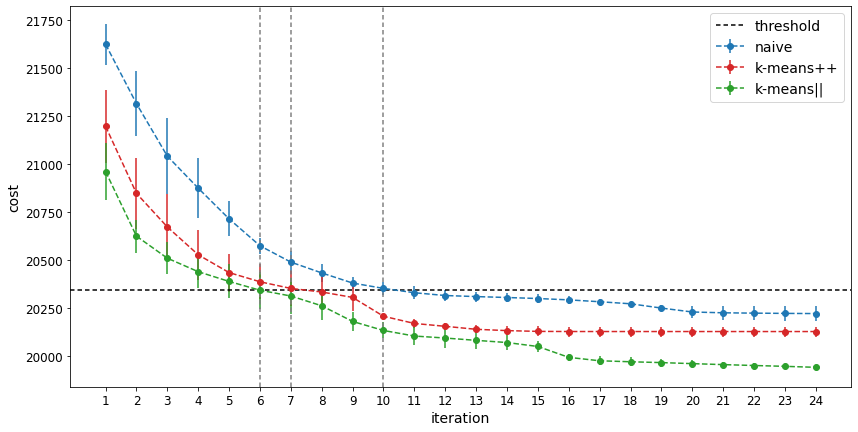

In [3]:
fig, ax = plt.subplots(figsize = (14, 7))

ax.errorbar(range(1, df_cost.shape[0]+1), df_cost['naive'], yerr = df_cost['naive-sd'],
            marker = 'o', ls = '--', color = 'tab:blue', label = 'naive')
ax.errorbar(range(1, df_cost.shape[0]+1), df_cost['k-means-pp'], yerr = df_cost['k-means-pp-sd'],
            marker = 'o', ls = '--', color = 'tab:red', label = 'k-means++')
ax.errorbar(range(1, df_cost.shape[0]+1), df_cost['k-means-ll'], yerr = df_cost['k-means-ll-sd'],
            marker = 'o', ls = '--', color = 'tab:green', label = 'k-means||')


ax.axvline(x = 6, color = 'gray', ls = '--', dashes = (3, 2))
ax.axvline(x = 7, color = 'gray', ls = '--', dashes = (3, 2))
ax.axvline(x = 10, color = 'gray', ls = '--', dashes = (3, 2))
ax.axhline(y = df_cost['k-means-ll'][7], color = 'k', ls = '--', dashes = (3, 2), label = 'threshold')


ax.set_xlabel('iteration', fontsize = 14)
ax.set_ylabel('cost', fontsize = 14)
ax.set_xticks(np.arange(df_cost.shape[0])+1)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)

plt.show()

# Compare the perfomances with different initializations: execution time
The setting for this comparison is the same as the previous one. From the graph below it is possible to see that the k-means|| initialization time is lower than the k-means++ one.

In [4]:
df_time = pd.read_csv('performances/k-means-time.csv')
df_time

,naive,k-means-pp,k-means-ll
0,0.490000,22.10,16.396667
1,781.493333,740.22,770.790000


In [5]:
t_init = np.array(df_time.iloc[0].tolist())
t_Lloyd = np.multiply(np.array(df_time.iloc[1].tolist())/24, np.array([10, 7, 6]))

k-means clustering execution time:

init method:   init time:  Lloyd time:  total time: 

       naive         0.49       325.62       326.11
   k-means++         22.1        215.9        238.0
   k-means||         16.4        192.7       209.09


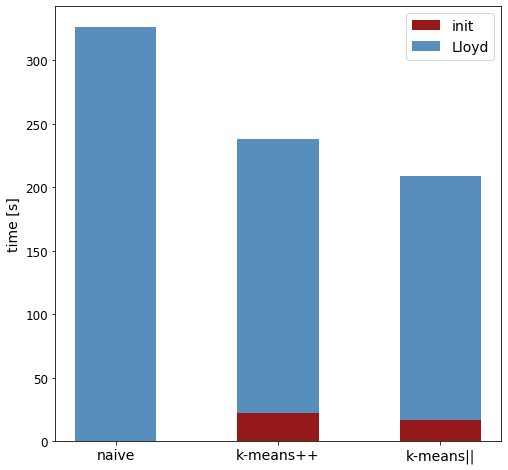

In [6]:
print('k-means clustering execution time:\n')
format_spec = '{:>12} {:>12} {:>12} {:>12}'

print(format_spec.format('init method:', 'init time:', 'Lloyd time:', 'total time:'), '\n')

names = ['naive', 'k-means++', 'k-means||']
for i, name in enumerate(names):
    times = [t_init[i], t_Lloyd[i], t_init[i] + t_Lloyd[i]]
    words = [str(round(t, 2)) for t in times]
    print(format_spec.format(name, words[0], words[1], words[2]))
    
fig, ax = plt.subplots(figsize = (8, 8))

ax.bar(names, t_init, width = 0.5, color = 'darkred', alpha = 0.9, label = 'init')
ax.bar(names, t_Lloyd, width = 0.5, bottom = t_init, color = 'steelblue', alpha = 0.9, label = 'Lloyd')
ax.set_ylabel('time [s]', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 12)
ax.legend(fontsize = 14)

plt.show()

# Study the perfomances of different Spark configurations
The dataset used for this comparison consisted of a total of 128000 documents (varying the number of chunks/partitions and the number of documents per chunk) tested using k-means|| initialization (l = 3, t = 5) and running the Lloyd's algorithm for 5 iterations. The small number of documents was necessary to run 5 executions in order to obtain the average execution time values. We considered two Spark configurations: the first consisted of 16 executors, each with 1 core and 1536 Mb of memory, while the second consisted of 8 executors, each with 2 cores and 3072 Mb of memory.

In [58]:
df_16exec = pd.read_csv('performances/spark-config-16exec.csv')
df_16exec

,t-init-mean,t-init-sd,t-Lloyd-mean,t-Lloyd-sd
0,27.770,1.538417,120.598,3.691748
1,15.728,0.616042,62.226,1.253927
2,10.962,0.380183,36.820,1.677288
3,13.926,0.183010,34.652,1.937556
4,19.786,0.126320,43.762,1.722100
5,30.504,0.801631,47.488,2.613698


In [59]:
df_8exec = pd.read_csv('performances/spark-config-8exec.csv')
df_8exec

,t-init-mean,t-init-sd,t-Lloyd-mean,t-Lloyd-sd
0,20.272,0.552372,116.854,4.344921
1,12.788,0.146490,64.690,1.289955
2,10.492,0.140610,34.662,1.210654
3,13.622,0.216968,39.012,0.915547
4,18.258,0.357249,38.456,1.719401
5,29.956,0.613942,44.704,1.181533


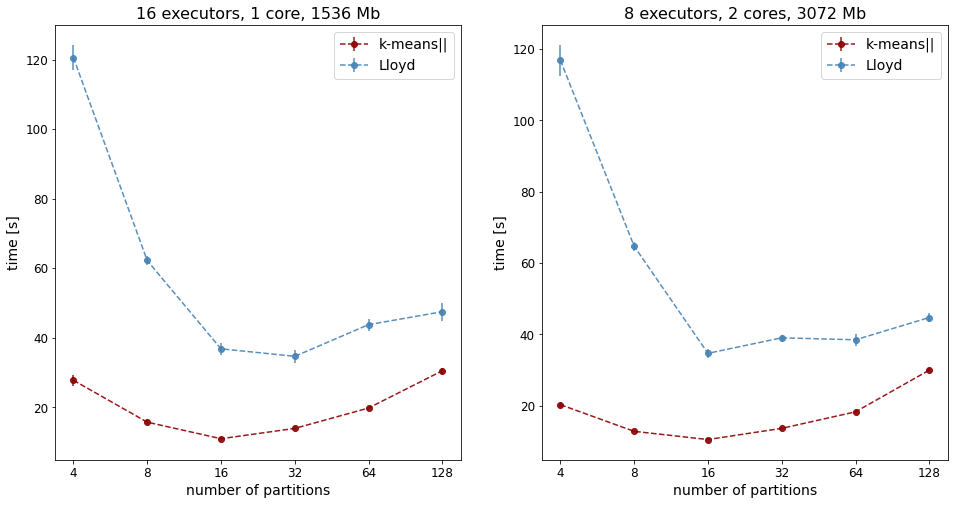

In [60]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))

# 16 executors
ax[0].errorbar(range(df_16exec.shape[0]), df_16exec['t-init-mean'], yerr = df_16exec['t-init-sd'],
            marker = 'o', ls = '--', color = 'darkred', alpha = 0.9, label = 'k-means||')
ax[0].errorbar(range(df_16exec.shape[0]), df_16exec['t-Lloyd-mean'], yerr = df_16exec['t-Lloyd-sd'],
            marker = 'o', ls = '--', color = 'steelblue', alpha = 0.9, label = 'Lloyd')

ax[0].set_xlabel('number of partitions', fontsize = 14)
ax[0].set_ylabel('time [s]', fontsize = 14)
ax[0].set_title('16 executors, 1 core, 1536 Mb', fontsize = 16)
ax[0].set_xticks(range(df_16exec.shape[0]), labels = ['4', '8', '16', '32', '64', '128'])
ax[0].tick_params(labelsize = 12)
ax[0].legend(fontsize = 14)

# 8 executors
ax[1].errorbar(range(df_8exec.shape[0]), df_8exec['t-init-mean'], yerr = df_8exec['t-init-sd'],
            marker = 'o', ls = '--', color = 'darkred', alpha = 0.9, label = 'k-means||')
ax[1].errorbar(range(df_8exec.shape[0]), df_8exec['t-Lloyd-mean'], yerr = df_8exec['t-Lloyd-sd'],
            marker = 'o', ls = '--', color = 'steelblue', alpha = 0.9, label = 'Lloyd')

ax[1].set_xlabel('number of partitions', fontsize = 14)
ax[1].set_ylabel('time [s]', fontsize = 14)
ax[1].set_title('8 executors, 2 cores, 3072 Mb', fontsize = 16)
ax[1].set_xticks(range(df_8exec.shape[0]), labels = ['4', '8', '16', '32', '64', '128'])
ax[1].tick_params(labelsize = 12)
ax[1].legend(fontsize = 14)

plt.show()

# References

[Scalable K-means++](https://arxiv.org/abs/1203.6402)